# Customer Churn Prediction - Telco Dataset

- Goal: Predict which customers are likely to cancel their subscription.
- Dataset: https://www.kaggle.com/blastchar/telco-customer-churn


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

## Download and Load Kaggle Dataset

In [3]:
download_path = ""
# Create the directory if it doesn't exist
# os.makedirs(download_path, exist_ok=True)
# Set the KAGGLEHUB_CACHE environment variable
os.environ["KAGGLEHUB_CACHE"] = download_path


In [4]:
import kagglehub # pip install kagglehub

dataset_identifier = "blastchar/telco-customer-churn"
kagglehub.dataset_download(
    dataset_identifier)

print("Path to dataset files:", download_path)

100%|██████████| 172k/172k [00:00<00:00, 230kB/s]


Extracting files...
Path to dataset files: 


In [6]:
import os

root_dir = os.getcwd()
target_file = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

for dirpath, dirnames, filenames in os.walk(root_dir):
    if target_file in filenames:
        path = os.path.join(dirpath, target_file)
        print("File found at:", path)
        break
else:
    print("File not found.")

File found at: /Volumes/TOSHIBA/Github Repositories/ds_projects/Project_8/datasets/blastchar/telco-customer-churn/versions/1/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [8]:
df = pd.read_csv(path)
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


## EDA

In [9]:
print(df.info())
print(df.describe())
# Check for missing values
print("\n Missing Values: \n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [10]:
# Convert TotalCharges to numeric, forcing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing TotalCharges with the median value
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

In [12]:
print(df.info()) # Total charges should now be float and no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


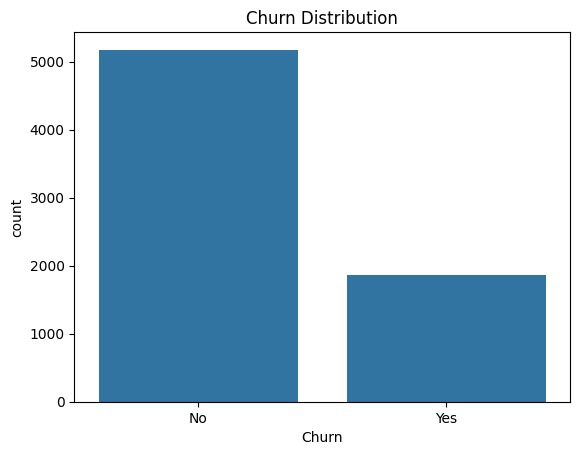

In [13]:
# Check churn distribution
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

In [14]:
# Percentage of churned customers
churn_percentage = df['Churn'].value_counts(normalize=True) * 100
print("\nChurn Percentage:\n", churn_percentage)


Churn Percentage:
 Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


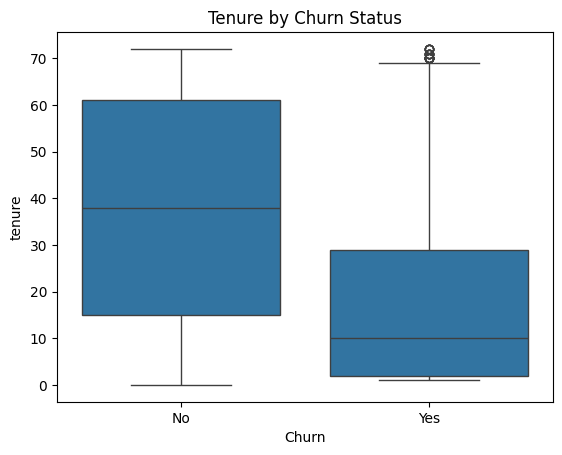

In [15]:
# Average tenure for churned vs non-churned customers
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Tenure by Churn Status')
plt.show()

## Preprocessing

In [16]:
# Drop customerID as it is not useful for prediction
df.drop('customerID', axis=1, inplace=True)

In [17]:
# Encode target variable 
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [18]:
# Encode categorical columns
cat_cols = df.select_dtypes('object').columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [ ]:
# Standardize numerical features
scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges'] 
df[num_cols] = scaler.fit_transform(df[num_cols])

## Train / Test Split

In [22]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [33]:
X_train

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
3738,0,0.107048,-0.517207,-0.256176,True,False,False,False,True,False,...,False,True,False,True,False,False,False,False,True,False
3151,0,-0.707359,0.343603,-0.499034,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,True
4860,0,-0.788800,-0.804698,-0.746793,True,True,True,False,True,False,...,False,False,False,False,False,True,False,False,False,True
3867,0,-0.259435,0.290426,-0.166092,False,True,False,True,False,False,...,False,True,False,True,False,True,True,True,False,False
3810,0,-1.277445,-0.671755,-0.987752,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6303,0,1.572981,1.478611,2.395373,False,True,False,True,False,True,...,False,True,False,True,False,True,False,False,True,False
6227,0,-1.236724,-0.621901,-0.971947,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4673,1,-0.300156,1.264239,0.167004,False,False,False,True,False,True,...,False,True,False,True,False,False,True,False,False,True
2710,0,-0.340876,-1.474403,-0.794274,False,True,False,True,False,False,...,True,False,True,False,True,False,False,True,False,False


In [34]:
y_train

3738    0
3151    0
4860    0
3867    0
3810    0
       ..
6303    0
6227    1
4673    1
2710    0
5639    0
Name: Churn, Length: 5634, dtype: int64

## Model Training

### Logistic Regression

In [26]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


### Random Forest

In [27]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### XGBoost

In [28]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## Eval Models

In [29]:
models = {'Logistic Regression': lr,
          'Random Forest': rf,
          'XGBoost': xgb}
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409

ROC-AUC: 0.8419954015861943

Random Forest Results:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

ROC-AUC: 0.8271009325996538

XGBoost Results:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.53      0.57       374

    accuracy                           0.78      1409


## Feature Importance

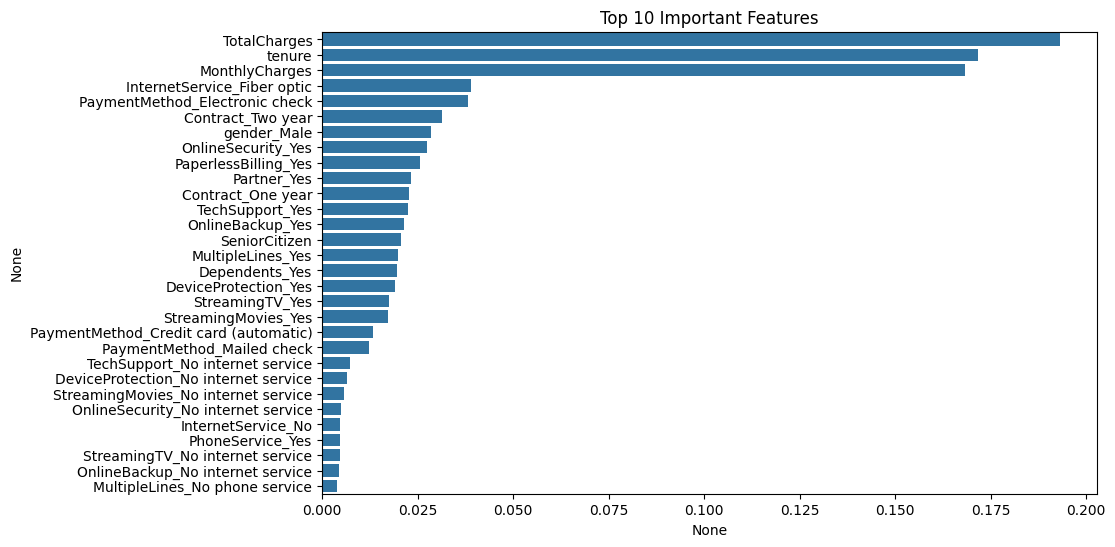

In [35]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_importances = importances.sort_values(ascending=False).head(30)
plt.figure(figsize=(10,6))
sns.barplot(x=top_importances, y=top_importances.index)
plt.title('Top 10 Important Features')
plt.show()

## Business Interpretation
Business Insight:
- Shorter tenure → high churn risk.
- Customers without contract (month-to-month) → more likely to churn.
- High monthly charges → slightly higher churn tendency.
- Electronic check payment → correlated with churn.

Actions:

✅ Offer long-term discounts for short-tenure customers.

✅ Target month-to-month users with special retention offers.

✅ Simplify billing methods for customers paying via electronic check.


## Save Models

In [32]:
import joblib
joblib.dump(lr, 'logistic_regression_model.pkl')
joblib.dump(rf, 'random_forest_model.pkl')
joblib.dump(xgb, 'xgboost_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [36]:
feature_list = X.columns.tolist()
joblib.dump(feature_list, 'feature_list.pkl')

['feature_list.pkl']